In [1]:
#imports
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import pandas as pd
import numpy as np
import dask_ml
#prefs
pd.set_option('max_columns', None)


In [2]:
#close existing dask connection if it exists and open a new one
try:
    if client is not None:
        client.close()
        print("closed existing connection, ",client)       
except Exception as e:
    print(e)
    

name 'client' is not defined


In [3]:
#get new connection
client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
display(client)

Client Scheduler: tcp://127.0.0.1:49980 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 14.90 GiB


In [4]:
#get stock data
data = dd.read_csv("Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv")
data2 = dd.read_csv("Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv")
#display(data.head())


In [5]:
data['Timestamp'] = dd.to_datetime(data.Timestamp, format='%d/%m/%Y %H:%M:%S').astype(np.int64)
data2['Timestamp'] = dd.to_datetime(data2.Timestamp, format='%d/%m/%Y %H:%M:%S').astype(np.int64)


In [6]:
tmp_data = data.loc[:, 'Dst Port':'Idle Min']
too_big = (tmp_data > np.finfo(np.float32).max)
too_big = (too_big).any()
with pd.option_context('max_rows', None):
    display(too_big.compute())

Dst Port             False
Protocol             False
Timestamp            False
Flow Duration        False
Tot Fwd Pkts         False
Tot Bwd Pkts         False
TotLen Fwd Pkts      False
TotLen Bwd Pkts      False
Fwd Pkt Len Max      False
Fwd Pkt Len Min      False
Fwd Pkt Len Mean     False
Fwd Pkt Len Std      False
Bwd Pkt Len Max      False
Bwd Pkt Len Min      False
Bwd Pkt Len Mean     False
Bwd Pkt Len Std      False
Flow Byts/s           True
Flow Pkts/s           True
Flow IAT Mean        False
Flow IAT Std         False
Flow IAT Max         False
Flow IAT Min         False
Fwd IAT Tot          False
Fwd IAT Mean         False
Fwd IAT Std          False
Fwd IAT Max          False
Fwd IAT Min          False
Bwd IAT Tot          False
Bwd IAT Mean         False
Bwd IAT Std          False
Bwd IAT Max          False
Bwd IAT Min          False
Fwd PSH Flags        False
Bwd PSH Flags        False
Fwd URG Flags        False
Bwd URG Flags        False
Fwd Header Len       False
B

In [7]:
#get labels for decision tree presentation, note the use of unique later 
labels = data['Label']
labels

Dask Series Structure:
npartitions=2
    object
       ...
       ...
Name: Label, dtype: object
Dask Name: getitem, 12 tasks

In [8]:
# Decide which features we want to include in our analysis

possible_features = 'Dst Port	Protocol	Timestamp	Flow Duration	Tot Fwd Pkts	Tot Bwd Pkts	TotLen Fwd Pkts	TotLen Bwd Pkts	Fwd Pkt Len Max	Fwd Pkt Len Min	Fwd Pkt Len Mean	Fwd Pkt Len Std	Bwd Pkt Len Max	Bwd Pkt Len Min	Bwd Pkt Len Mean	Bwd Pkt Len Std	Flow Byts/s	Flow Pkts/s	Flow IAT Mean	Flow IAT Std	Flow IAT Max	Flow IAT Min	Fwd IAT Tot	Fwd IAT Mean	Fwd IAT Std	Fwd IAT Max	Fwd IAT Min	Bwd IAT Tot	Bwd IAT Mean	Bwd IAT Std	Bwd IAT Max	Bwd IAT Min	Fwd PSH Flags	Bwd PSH Flags	Fwd URG Flags	Bwd URG Flags	Fwd Header Len	Bwd Header Len	Fwd Pkts/s	Bwd Pkts/s	Pkt Len Min	Pkt Len Max	Pkt Len Mean	Pkt Len Std	Pkt Len Var	FIN Flag Cnt	SYN Flag Cnt	RST Flag Cnt	PSH Flag Cnt	ACK Flag Cnt	URG Flag Cnt	CWE Flag Count	ECE Flag Cnt	Down/Up Ratio	Pkt Size Avg	Fwd Seg Size Avg	Bwd Seg Size Avg	Fwd Byts/b Avg	Fwd Pkts/b Avg	Fwd Blk Rate Avg	Bwd Byts/b Avg	Bwd Pkts/b Avg	Bwd Blk Rate Avg	Subflow Fwd Pkts	Subflow Fwd Byts	Subflow Bwd Pkts	Subflow Bwd Byts	Init Fwd Win Byts	Init Bwd Win Byts	Fwd Act Data Pkts	Fwd Seg Size Min	Active Mean	Active Std	Active Max	Active Min	Idle Mean	Idle Std	Idle Max	Idle Min'.split('\t')

exclude_features = ('Timestamp', 'Flow Byts/s', 'Flow Pkts/s', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Rate Avg', 'Pkt Size Avg', 'Fwd Header Len', 'Bwd Header Len', 'Down/Up Ratio', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min')

features = [f for f in possible_features if f not in exclude_features]


In [9]:
#get dataframe of just features
X = data.loc[:, features]
X

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,int64,int64,int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [10]:
#setup plot
import matplotlib.pyplot as plt
print(plt.rcParams.get('figure.figsize'))

[6.0, 4.0]


In [11]:
#setup figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

In [12]:
Y = labels

In [13]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)

In [14]:
# from dask_ml.model_selection import KFold as K
from dask_ml.model_selection import train_test_split


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:462: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [16]:
# instead of using test data from split, use an entirely new csv file
test = data2.loc[:,features]
test_labels = data2['Label']

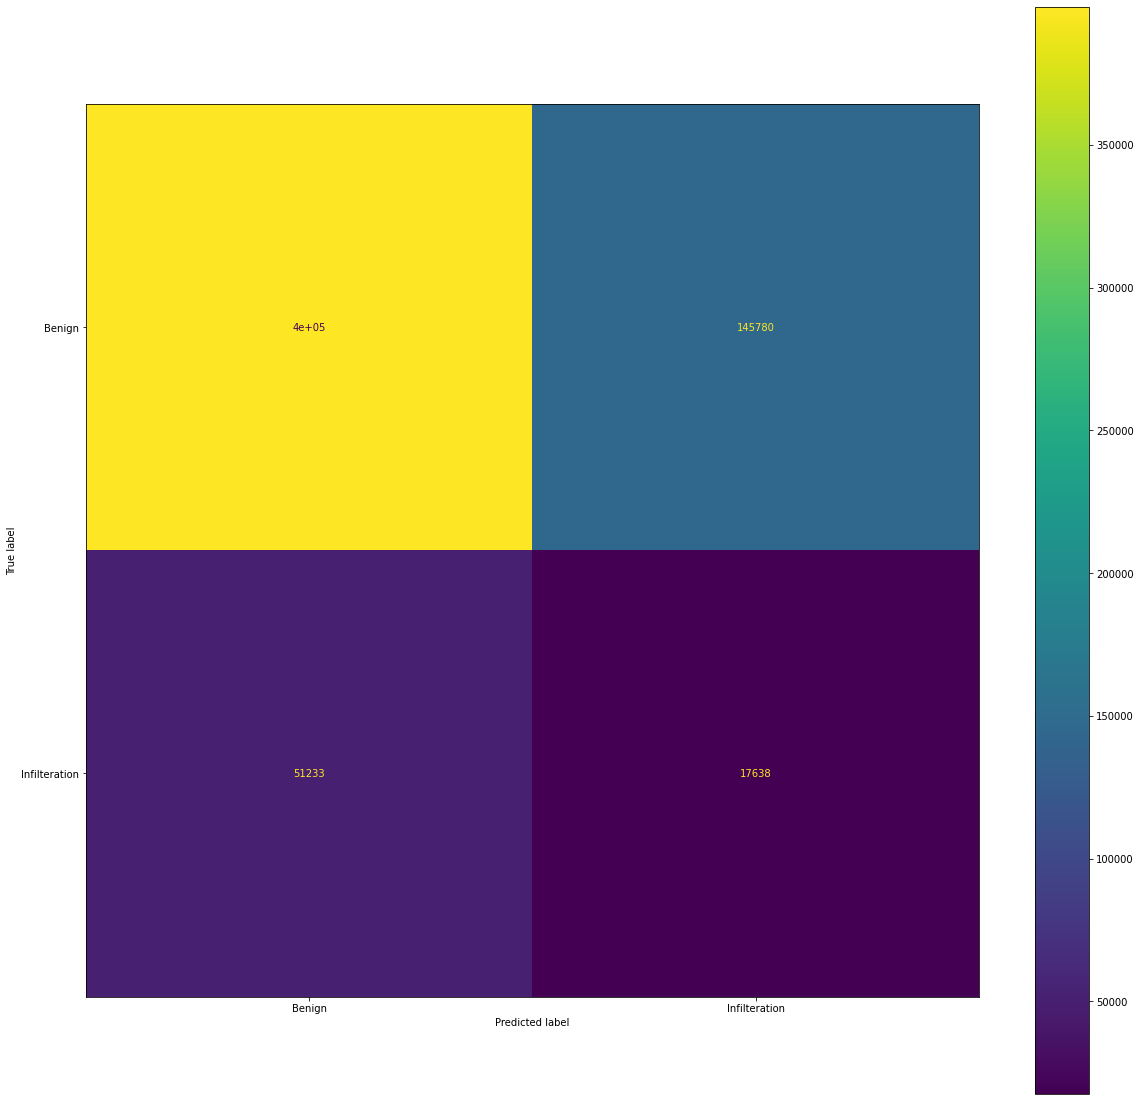

In [17]:
from sklearn.metrics import plot_confusion_matrix

#fit and predict
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, test, test_labels)
# plot_confusion_matrix(clf, X_test, y_test)

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(test_labels, clf.predict(test), pos_label='Benign')

0.8860610292825801

In [19]:
recall_score(test_labels, clf.predict(test), pos_label='Benign')

0.7321205439176773

In [20]:
import joblib as joblib

In [21]:
%%timeit -n 10
#time with just pandas
with joblib.parallel_backend('threading'):
     clf.fit(test, test_labels)


44 s ± 753 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit -n 10
#time with dask
with joblib.parallel_backend('dask'):
     clf.fit(X_train, y_train)


#clf = clf.fit(X, Y)

19 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
# clf.fit(X, Y)
clf.fit(test, test_labels)


DecisionTreeClassifier(random_state=0)

In [29]:
%%timeit -n 10
#time with dask, even if you set threading it's still a dask dataframe so it's produced via dasks engine
with joblib.parallel_backend('threading'):
     clf.fit(test, test_labels)

#clf = clf.fit(X, Y)

42.2 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
#cache results note you have to assign in X and Y
X = client.persist(test)
Y = client.persist(test_labels)

In [31]:
%%timeit -n 10
#time with dask after cache
with joblib.parallel_backend('dask'):
     clf.fit(test, test_labels)

45.2 s ± 12.8 s per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%timeit -n 10
#time with just pandas once X and Y are cached
with joblib.parallel_backend('threading'):
     clf.fit(test, test_labels)

55.4 s ± 7.56 s per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
tree.plot_tree(clf,feature_names=features,class_names=labels.astype(str),rounded=True,filled=True) 
# tree.plot_tree(clf) 


NotImplementedError: Series getitem in only supported for other series objects with matching partition structure

In [ ]:
# from sklearn.svm import OneClassSVM
# clf = OneClassSVM(gamma='auto').fit(test)
# clf.predict(test)

In [28]:
# attempt at looking at correlations between features
# import seaborn as sns
# plt.figure(figsize=(15,10))
# sns.heatmap(X.corr(), annot=True)